In [168]:
print("hello world")

hello world


In [191]:
from dotenv import load_dotenv
import os
load_dotenv()



True

In [192]:
from langchain_google_genai import ChatGoogleGenerativeAI

In [193]:
gemini_api_key = os.getenv("gemini_api_key")

In [ ]:
if not gemini_api_key:
    raise ValueError("No Gemini API key found. Please set the GEMINI_API_KEY environment variable.")

chat_llm = ChatGoogleGenerativeAI(model="gemini-3-flash-preview", google_api_key=gemini_api_key)




In [197]:
chat_llm.invoke("hi")

ChatGoogleGenerativeAIError: Error calling model 'gemini-3-flash' (INVALID_ARGUMENT): 400 INVALID_ARGUMENT. {'error': {'code': 400, 'message': 'API key expired. Please renew the API key.', 'status': 'INVALID_ARGUMENT', 'details': [{'@type': 'type.googleapis.com/google.rpc.ErrorInfo', 'reason': 'API_KEY_INVALID', 'domain': 'googleapis.com', 'metadata': {'service': 'generativelanguage.googleapis.com'}}, {'@type': 'type.googleapis.com/google.rpc.LocalizedMessage', 'locale': 'en-US', 'message': 'API key expired. Please renew the API key.'}]}}

In [172]:
from typing_extensions import TypedDict, Annotated
import operator

In [173]:
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage

In [174]:
class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [175]:
["hi"]

['hi']

In [176]:
["hi", "how are you"]

['hi', 'how are you']

In [177]:
def llm_call(state: GraphState) -> dict:
    """Call the LLM using conversation messages and append AI response."""
    response = chat_llm.invoke(state["messages"])  # AIMessage
    return {
        "messages": [response]
    }

In [178]:
def token_counter(state: GraphState) -> dict:
    """Count tokens (simple word count) in the last AI message."""
    last_msg = state["messages"][-1]
    content = last_msg.content
    # AIMessage.content can be str or list of blocks (e.g. multimodal/tool calls)
    if isinstance(content, list):
        text = " ".join(
            (c.get("text", c) if isinstance(c, dict) else str(c)) for c in content
        )
    else:
        text = content or ""
    token_number = len(text.split())
    summary = f"Total token number in the generated answer (word count) is {token_number}"
    return {
        "messages": [AIMessage(content=summary)]
    }


In [179]:
from langgraph.graph import StateGraph

In [180]:
builder = StateGraph(GraphState)

In [181]:

builder.add_node("llm_call", llm_call)
builder.add_node("token_counter", token_counter)

In [182]:
builder.set_entry_point("llm_call")
builder.add_edge("llm_call", "token_counter")
builder.set_finish_point("token_counter")

In [183]:
app = builder.compile()

In [184]:
app.get_graph()

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=RunnableCallable(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'llm_call': Node(id='llm_call', name='llm_call', data=llm_call(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'token_counter': Node(id='token_counter', name='token_counter', data=token_counter(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), '__end__': Node(id='__end__', name='__end__', data=None, metadata=None)}, edges=[Edge(source='__start__', target='llm_call', data=None, conditional=False), Edge(source='llm_call', target='token_counter', data=None, conditional=False), Edge(source='token_counter', target='__end__', data=None, conditional=False)])

In [185]:
from IPython.display import Image, display

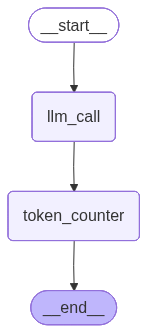

In [186]:

display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
result = app.invoke({
    "messages": [HumanMessage(content="Hi, this is Sunny. Say hello in detail.")]
})

In [ ]:
result